In [1]:
# -----------------------------------------
# Linear Regression Health Costs Calculator
# -----------------------------------------

# Import libraries. You may or may not use all of these.
%pip install -q git+https://github.com/tensorflow/docs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%pip install seaborn
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling


[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: C:\Users\Mofey\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.




[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: C:\Users\Mofey\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
dataset = pd.read_csv('insurance.csv')
dataset.tail()

,age,sex,bmi,children,smoker,region,expenses
1333,50,male,31.0,3,no,northwest,10600.55
1334,18,female,31.9,0,no,northeast,2205.98
1335,18,female,36.9,0,no,southeast,1629.83
1336,21,female,25.8,0,no,southwest,2007.95
1337,61,female,29.1,0,yes,northwest,29141.36


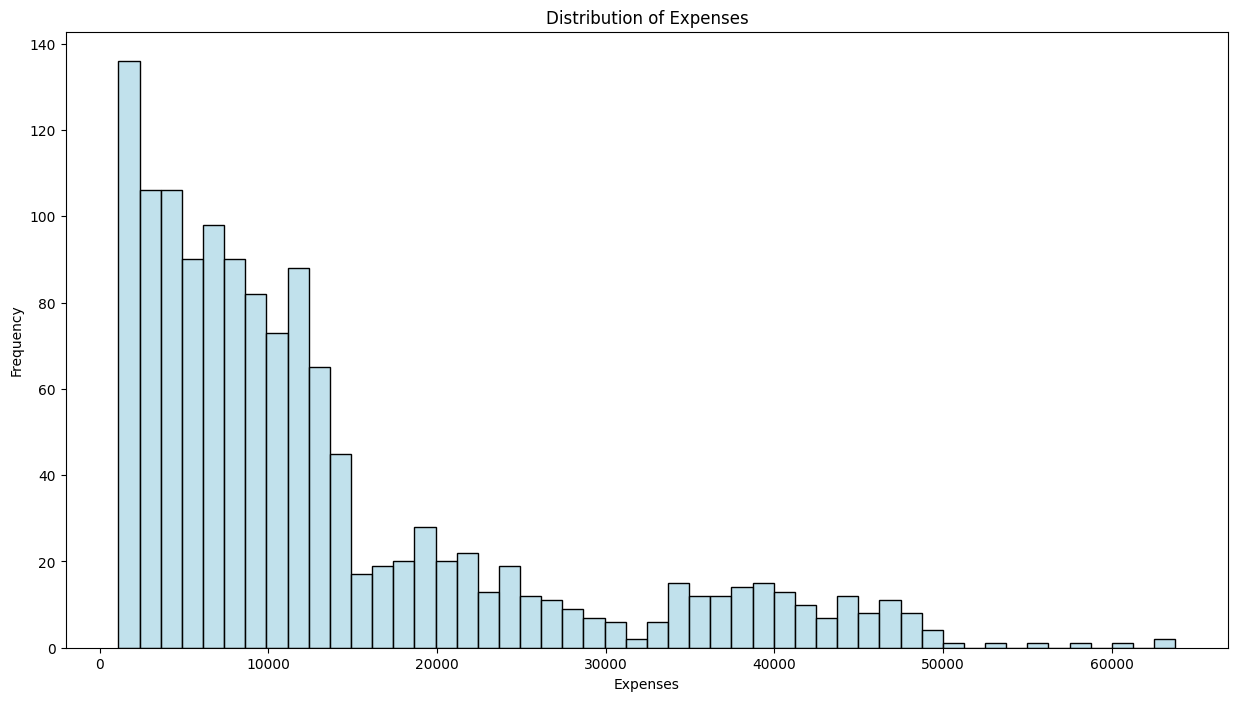

Missing values per column:
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
expenses    0
dtype: int64

DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   expenses  1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB

Unique regions:
['southwest' 'southeast' 'northwest' 'northeast']

Last few rows of encoded DataFrame:
      age   bmi  children  expenses  female   male  smoker_no  smoker_yes  \
1333   50  31.0         3  10600.55   False   True       True       False   
1334   18  31.9         0   2205.98    True  False       True      

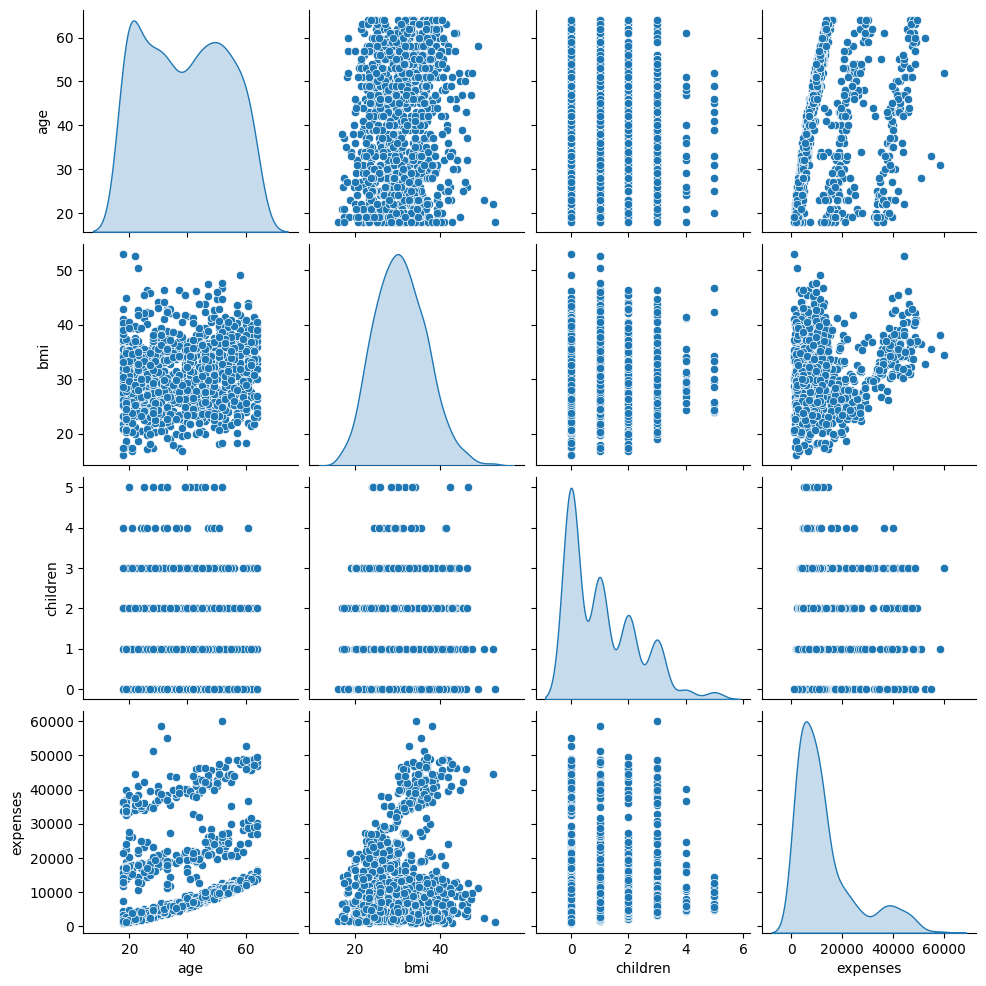


Training dataset summary:
           count          mean           std      min       25%       50%  \
age       1070.0     39.036449     14.142122    18.00    26.000    39.000   
bmi       1070.0     30.737290      6.065193    16.00    26.300    30.500   
children  1070.0      1.093458      1.211364     0.00     0.000     1.000   
expenses  1070.0  13056.551654  11994.260172  1121.87  4565.995  9289.085   

                 75%      max  
age          51.0000     64.0  
bmi          34.8000     53.1  
children      2.0000      5.0  
expenses  15826.1125  60021.4  

Features statistics (mean and standard deviation):
               mean        std
age       39.036449  14.142122
bmi       30.737290   6.065193
children   1.093458   1.211364


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (1070, 11)             │            23 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23 (96.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23 (96.00 B)

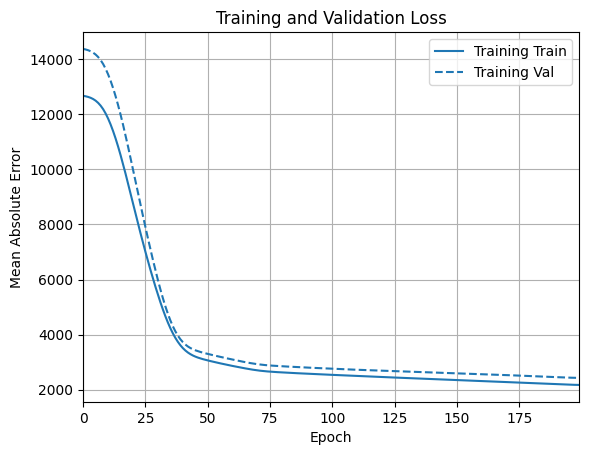

In [3]:
df = dataset.copy()

# Exploratory Data Analysis

# Plot histogram of the 'expenses' column
plt.figure(figsize=(15, 8))
sns.histplot(df['expenses'], bins=50, color='lightblue', edgecolor='black')
plt.title("Distribution of Expenses")
plt.xlabel("Expenses")
plt.ylabel("Frequency")
plt.show()

# Check for missing values and display DataFrame information
print("Missing values per column:")
print(df.isna().sum())
print("\nDataFrame info:")
df.info()
print("\nUnique regions:")
print(df['region'].unique())


# Data Preprocessing

# One-hot encode the categorical columns
df_encoded = pd.get_dummies(df, columns=['sex', 'smoker', 'region'],
                              prefix=['', 'smoker_', ''],
                              prefix_sep='')

# Show the last few rows and info of the encoded DataFrame
print("\nLast few rows of encoded DataFrame:")
print(df_encoded.tail())
print("\nEncoded DataFrame information:")
df_encoded.info()


# Train/Test Split

# Randomly sample 80% of the data for training; the rest for testing
train_df = df_encoded.sample(frac=0.8, random_state=0)
test_df = df_encoded.drop(train_df.index)

# Use a pairplot to visualize key features (age, bmi, children, expenses)
sns.pairplot(train_df[['age', 'bmi', 'children', 'expenses']], diag_kind='kde')
plt.show()

# Display summary statistics of the training dataset
print("\nTraining dataset summary:")
print(train_df.describe().transpose())


# Separate Features and Labels

# Copy training and testing DataFrames
train_features = train_df.copy()
test_features = test_df.copy()

# Remove the 'expenses' column from features and store it as labels
train_labels = train_features.pop('expenses')
test_labels = test_features.pop('expenses')

print("\nFeatures statistics (mean and standard deviation):")
print(train_features.describe().transpose()[['mean', 'std']])

# Create and adapt a normalization layer using TensorFlow
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))

# Helper function to plot training and validation loss
def plot_loss(history):
    plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
    plotter.plot({'Training': history}, 'loss')
    plt.title("Training and Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Mean Absolute Error")
    plt.grid(True)
    plt.show()

# Function to build a simple neural network model
def build_model(norm_layer):
    model = keras.Sequential([
        norm_layer,
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                  loss='mean_absolute_error',
                  metrics=['mae', 'mse'])
    return model

# Build and summarize the model
model = build_model(normalizer)
model.summary()

# Train the model for 200 epochs with a validation split of 20%
history = model.fit(train_features, train_labels,
                    validation_split=0.2,
                    epochs=200,
                    verbose=0)

# Plot training history
plot_loss(history)

9/9 - 0s - 9ms/step - loss: 3112.8257 - mae: 3112.8257 - mse: 40422840.0000
Testing set Mean Abs Error: 3112.83 expenses
You passed the challenge. Great job!
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


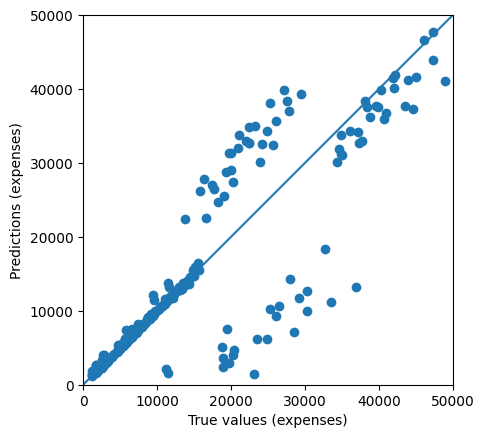

In [4]:
# RUN THIS CELL TO TEST YOUR MODEL. DO NOT MODIFY CONTENTS.
# Test model by checking how well the model generalizes using the test set.
loss, mae, mse = model.evaluate(test_features, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} expenses".format(mae))

if mae < 3500:
  print("You passed the challenge. Great job!")
else:
  print("The Mean Abs Error must be less than 3500. Keep trying.")

# Plot predictions.
test_predictions = model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True values (expenses)')
plt.ylabel('Predictions (expenses)')
lims = [0, 50000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims,lims)
